In [1]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ../web-app/

/Users/dorislee/Desktop/Fall2016/Research/seg/crowd-seg/web-app


In [3]:
%load_ext autoreload
%autoreload 2
from analysis_toolbox import *

In [4]:
import ast
import matplotlib.image as mpimg

In [5]:
save_db_as_csv()

In [6]:
img_info,object_tbl,bb_info,hit_info = load_info()

/Users/dorislee/.virtualenvs/py27dev/lib/python2.7/site-packages/pandas/io/parsers.py:648: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer; you can avoid this warning by specifying engine='python'.
  ParserWarning)


For the work quality evaluation methods, given a list of x_locs and y_locs of all of the worker's bounding boxes and sizes of the image, for the same object, return what should be "best region" and confidence score 

/Users/dorislee/.virtualenvs/py27dev/lib/python2.7/site-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


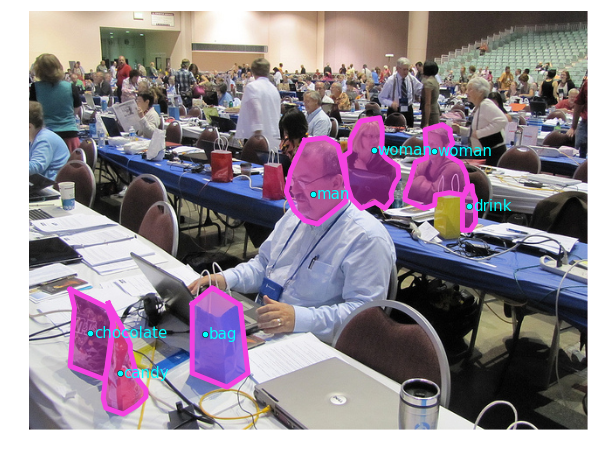

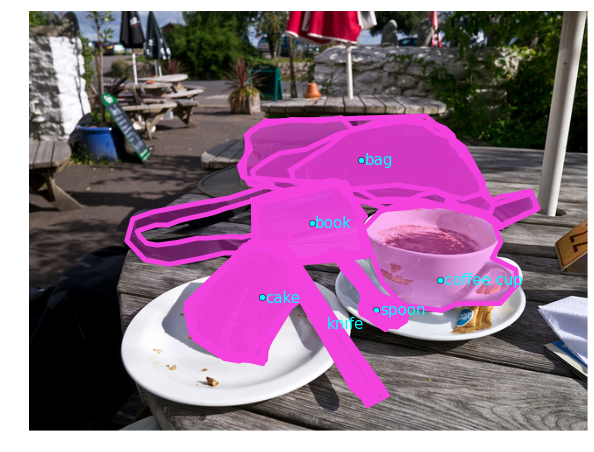

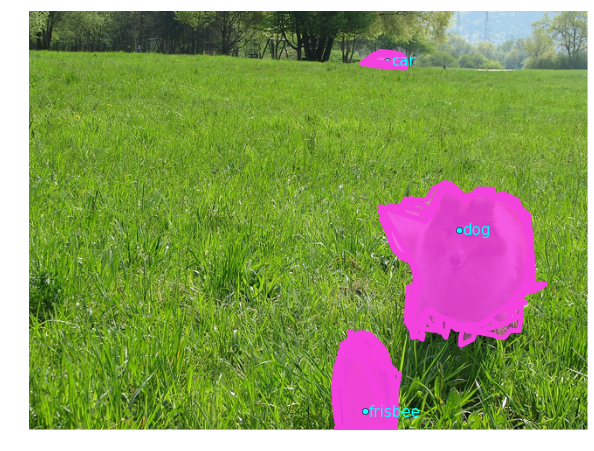

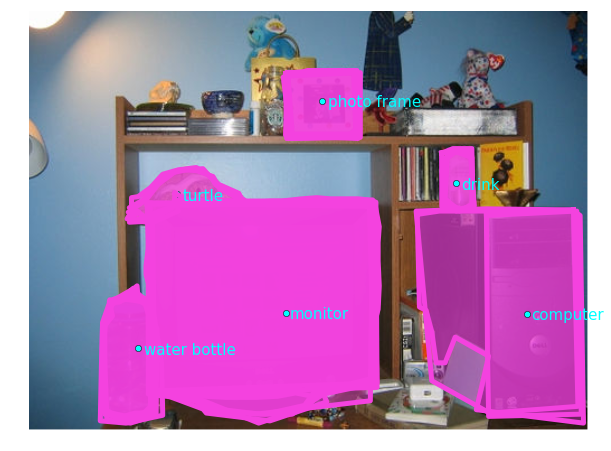

In [9]:
all_x_locs = {}
all_y_locs = {}
for i in np.arange(len(img_info)-5):
    img_name = img_info["filename"][i]
    if 'COCO' in img_name:
        fname = "app/static/"+img_name+".png"
        img=mpimg.imread(fname)
        width,height = get_size(fname)
        plt.figure(figsize =(10,10))
        plt.imshow(img)
        plt.axis("off")
        filtered_object_tbl = object_tbl[object_tbl["image_id"]==i+1]
        plt.plot(filtered_object_tbl["x_loc"],filtered_object_tbl["y_loc"],'o',color="cyan")
        for name, x,y in zip(filtered_object_tbl["name"],filtered_object_tbl["x_loc"],filtered_object_tbl["y_loc"]):
            plt.text(x+5,y+5,name, fontsize=15,color='cyan')
        #Draw Collected Bounding Boxes
        for oid,bbx_path,bby_path in zip(bb_info["object_id"],bb_info["x_locs"],bb_info["y_locs"]):
            if int(object_tbl[object_tbl.object_id==oid].image_id) ==i+1:
                objid = int(object_tbl[object_tbl.object_id==oid].object_id)
                x_locs = ast.literal_eval(bbx_path)
                y_locs = ast.literal_eval(bby_path)
                # Append the starting point again in the end to close the BB
                x_locs.append(x_locs[0])
                y_locs.append(y_locs[0])
                if objid in all_x_locs.keys():
                    all_x_locs[objid].append(x_locs)
                    all_y_locs[objid].append(y_locs)                    
                else:
                    all_x_locs[objid]=[x_locs]
                    all_y_locs[objid]=[y_locs]
                plt.plot(x_locs,y_locs,'-',color="#f442df",linewidth=5)
                plt.fill_between(x_locs,y_locs,  color="none",facecolor='#f442df', alpha=0.4)
        plt.xlim(0,width)
        plt.ylim(height,0)

In [44]:
import math, random

def generatePolygon( ctrX, ctrY, aveRadius, irregularity, spikeyness, numVerts ) :
    '''
    Start with the centre of the polygon at ctrX, ctrY, 
    then creates the polygon by sampling points on a circle around the centre. 
    Randon noise is added by varying the angular spacing between sequential points,
    and by varying the radial distance of each point from the centre.

    Params:
    ctrX, ctrY - coordinates of the "centre" of the polygon
    aveRadius - in px, the average radius of this polygon, this roughly controls how large the polygon is, really only useful for order of magnitude.
    irregularity - [0,1] indicating how much variance there is in the angular spacing of vertices. [0,1] will map to [0, 2pi/numberOfVerts]
    spikeyness - [0,1] indicating how much variance there is in each vertex from the circle of radius aveRadius. [0,1] will map to [0, aveRadius]
    numVerts - self-explanatory

    Returns a list of vertices, in CCW order.
    
    Modified from Mike Ounsworth
    http://stackoverflow.com/questions/8997099/algorithm-to-generate-random-2d-polygon
    '''
    x_locs = []
    y_locs = []
    irregularity = clip( irregularity, 0,1 ) * 2*math.pi / numVerts
    spikeyness = clip( spikeyness, 0,1 ) * aveRadius

    # generate n angle steps
    angleSteps = []
    lower = (2*math.pi / numVerts) - irregularity
    upper = (2*math.pi / numVerts) + irregularity
    sum = 0
    for i in range(numVerts) :
        tmp = random.uniform(lower, upper)
        angleSteps.append( tmp )
        sum = sum + tmp

    # normalize the steps so that point 0 and point n+1 are the same
    k = sum / (2*math.pi)
    for i in range(numVerts) :
        angleSteps[i] = angleSteps[i] / k

    # now generate the points
    angle = random.uniform(0, 2*math.pi)
    for i in range(numVerts) :
        r_i = clip( random.gauss(aveRadius, spikeyness), 0, 2*aveRadius )
        x = ctrX + r_i*math.cos(angle)
        y = ctrY + r_i*math.sin(angle)
        x_locs.append(int(x))
        y_locs.append(int(y))

        angle = angle + angleSteps[i]
    # Closing up the polygon 
    x_locs.append(x_locs[0])
    y_locs.append(y_locs[0])
    return x_locs, y_locs

def clip(x, min, max) :
    if( min > max ) :  return x    
    elif( x < min ) :  return min
    elif( x > max ) :  return max
    else :             return x

In [45]:
x_locs,y_locs = generatePolygon( ctrX=250, ctrY=250, aveRadius=100, irregularity=0.35, spikeyness=0.2, numVerts=16 )

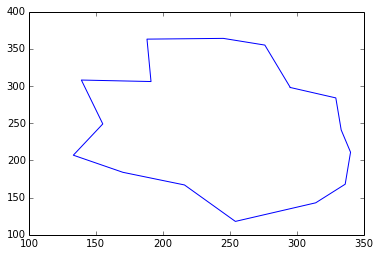

In [46]:
plt.plot(x_locs,y_locs)

In [38]:
verts

[(294, 337),
 (264, 339),
 (230, 328),
 (188, 348),
 (158, 303),
 (166, 260),
 (127, 211),
 (189, 194),
 (222, 175),
 (248, 164),
 (287, 142),
 (360, 149),
 (357, 209),
 (358, 250),
 (361, 293),
 (326, 309)]

In [50]:
def simulateBB():
    Nworkers = random.randint(2,35)
    obj_x_locs = []
    obj_y_locs = []
    for worker in np.arange(Nworkers):
        obj_xy_locs = generatePolygon( ctrX=250, ctrY=250, aveRadius=100, irregularity=0.35, spikeyness=0.2, numVerts=16 )
        obj_x_locs.append(obj_xy_locs[0])
        obj_y_locs.append(obj_xy_locs[1])
    return obj_x_locs,obj_y_locs

In [51]:
obj_x_locs,obj_y_locs = simulateBB()

In [52]:
# obj_x_locs = all_x_locs[objid]
# obj_y_locs = all_y_locs[objid]

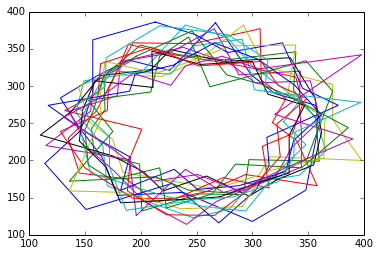

In [55]:
for x,y in zip(obj_x_locs,obj_y_locs):
    plt.plot(x,y)

In [60]:
def majority_vote(obj_x_locs ,obj_y_locs,width,height): 
    '''
    Jaccard Simmilarity or Overlap Method
    used for PASCAL VOC challenge
    
    If you want to compare with ground truth, just feed in : 
    obj_x_locs = [[worker responses],[ground truth]]
    obj_y_locs = [[worker responses],[ground truth]]
    '''
    mega_mask = np.zeros((height,width))
    img = Image.new('L', (width, height), 0)
    for x_locs, y_locs in zip(obj_x_locs,obj_y_locs):
        ImageDraw.Draw(img).polygon(zip(x_locs,y_locs), outline=1, fill=1)
        mask = numpy.array(img)==1
    #     plt.imshow(mask)
        mega_mask+=mask
    #     plt.plot(x_locs,y_locs,'-',color="#f442df",linewidth=5)
    #     plt.fill_between(x_locs,y_locs,  color="none",facecolor='#f442df', alpha=0.4)
    # Show Majority Vote area
    plt.imshow(mega_mask)
    plt.colorbar()
    # Compute Jaccard Simmilarity 
    intersection = len(np.where(mega_mask == mega_mask.max())[0])
    union  =len(np.where(mega_mask !=0)[0])
    return float(union)/intersection

1.5358134675135418

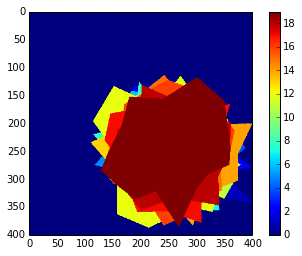

In [59]:
from PIL import Image, ImageDraw
majority_vote(obj_x_locs,obj_y_locs,400,400)

In [61]:
from scipy import spatial

In [78]:
sum(spatial.distance.pdist(np.array([x,y]).T,'euclidean'))

17846.242709388982

In [193]:
bb1 = np.array([obj_x_locs[0],obj_y_locs[0]]).T

In [194]:
bb2  = np.array([obj_x_locs[1],obj_y_locs[1]]).T

In [195]:
from munkres import Munkres, print_matrix

In [197]:
# matrix[matrix==0]=99999

In [198]:
# m = Munkres()
# indexes = m.compute(matrix)

In [196]:
matrix = spatial.distance.cdist(bb1,bb2,'euclidean')
m = Munkres()
indexes = m.compute(np.ma.masked_equal(matrix,0))

In [200]:
total = 0
for row, column in indexes:
    value = matrix[row][column]
    total += value
    print '(%d, %d) -> %d' % (row, column, value)
print 'total cost: %d' % total

(0, 0) -> 50
(1, 1) -> 22
(2, 2) -> 22
(3, 3) -> 7
(4, 4) -> 43
(5, 5) -> 13
(6, 6) -> 9
(7, 8) -> 30
(8, 7) -> 54
(9, 9) -> 59
(10, 10) -> 56
(11, 12) -> 9
(12, 11) -> 74
(13, 13) -> 18
(14, 14) -> 17
(15, 15) -> 50
(16, 16) -> 50
total cost: 591


In [202]:
print obj_x_locs

[[267, 226, 189, 160, 128, 143, 165, 179, 238, 300, 348, 354, 359, 357, 320, 299, 267], [276, 234, 200, 167, 168, 156, 158, 199, 201, 253, 292, 297, 360, 357, 337, 339, 276], [318, 330, 308, 307, 247, 193, 174, 160, 135, 145, 187, 214, 259, 294, 358, 340, 318], [247, 279, 301, 342, 366, 356, 330, 300, 277, 240, 201, 149, 142, 166, 170, 211, 247], [136, 153, 176, 203, 241, 268, 304, 344, 344, 342, 343, 288, 266, 225, 182, 179, 136], [267, 306, 316, 398, 372, 372, 311, 292, 251, 219, 173, 144, 154, 175, 184, 225, 267], [322, 355, 362, 356, 334, 274, 227, 209, 164, 138, 110, 175, 203, 220, 259, 297, 322], [213, 157, 157, 146, 114, 151, 228, 270, 303, 315, 313, 377, 345, 327, 278, 249, 213], [321, 349, 356, 372, 348, 290, 262, 243, 217, 209, 153, 175, 136, 213, 243, 282, 321], [189, 171, 170, 128, 150, 193, 232, 274, 315, 309, 336, 345, 339, 290, 259, 230, 189], [328, 345, 302, 291, 248, 227, 176, 161, 145, 149, 155, 206, 256, 294, 322, 348, 328], [196, 240, 274, 299, 321, 335, 361, 352, 3

In [209]:
minDistList=[]
for i in np.arange(len(obj_x_locs)-1):
    # Compare worker with another worker
    bb1 = np.array([obj_x_locs[i],obj_y_locs[i]]).T
    bb2  = np.array([obj_x_locs[i+1],obj_y_locs[i+1]]).T
    matrix = spatial.distance.cdist(bb1,bb2,'euclidean')
    m = Munkres()
    indexes = m.compute(np.ma.masked_equal(matrix,0))
    
    total = 0
    for row, column in indexes:
        value = matrix[row][column]
        total += value
#         print '(%d, %d) -> %d' % (row, column, value)
    minDistList.append(total)

In [213]:
#worker's scores
minDistList/max(minDistList)

array([ 0.76248663,  0.63416375,  0.73839696,  0.61564846,  0.68043713,
        0.58430008,  1.        ,  0.87548934,  0.80176739,  0.63792301,
        0.75641954,  0.83703518,  0.75904276,  0.4765704 ,  0.62386647,
        0.63543114,  0.68150884,  0.88108523])

In [218]:
sum(matrix[np.array(indexes)])

78456.164410206999

In [219]:
from itertools import combinations

In [222]:
list(combinations(np.arange(len(obj_x_locs)),2))

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (0, 15),
 (0, 16),
 (0, 17),
 (0, 18),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (1, 10),
 (1, 11),
 (1, 12),
 (1, 13),
 (1, 14),
 (1, 15),
 (1, 16),
 (1, 17),
 (1, 18),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (2, 10),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 14),
 (2, 15),
 (2, 16),
 (2, 17),
 (2, 18),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (3, 9),
 (3, 10),
 (3, 11),
 (3, 12),
 (3, 13),
 (3, 14),
 (3, 15),
 (3, 16),
 (3, 17),
 (3, 18),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (4, 9),
 (4, 10),
 (4, 11),
 (4, 12),
 (4, 13),
 (4, 14),
 (4, 15),
 (4, 16),
 (4, 17),
 (4, 18),
 (5, 6),
 (5, 7),
 (5, 8),
 (5, 9),
 (5, 10),
 (5, 11),
 (5, 12),
 (5, 13),
 (5, 14),
 (5, 15),
 (5, 16),
 (5, 17),
 (5, 18),
 (6, 7),
 (6, 8),
 (6, 9),
 (6, 10),
 (6, 11),
 (6, 12),
 (6, 13),
 (6, 14),
 (6, 15),
 (6, 16),
 (6, 17),
 (

In [ ]:
# def DistAllWorkers(obj_x_locs,obj_y_locs,dist = MunkresEuclidean):
#     '''
#     Given all worker's responses,
#     Perform pairwise distance comparison with all other workers
#     '''
#     minDistList=[]
#     for i in np.arange(len(obj_x_locs)-1):
#         bb1 = np.array([obj_x_locs[i],obj_y_locs[i]]).T
#         for j in np.arange(len(obj_x_locs)-1):
#             # Compare worker with another worker
#             bb2  = np.array([obj_x_locs[j],obj_y_locs[j]]).T
#             minDistList.append(dist(bb1,bb2))
#     #worker's scores
#     print minDistList
#     return minDistList/max(minDistList)

In [232]:
def DistAllWorkers(obj_x_locs,obj_y_locs,dist = MunkresEuclidean):
    '''
    Given all worker's responses,
    Perform pairwise distance comparison with all other workers
    returns quality for each worker
    #NOTE THIS NEEDS TO BE CHANGED TO INCORPORATE ALL PAIRWISE COMPARISONS
    '''
    minDistList=[]
    for i in np.arange(len(obj_x_locs)-1):
        # Compare worker with another worker
        bb1 = np.array([obj_x_locs[i],obj_y_locs[i]]).T
        bb2  = np.array([obj_x_locs[i+1],obj_y_locs[i+1]]).T
        minDistList.append(dist(bb1,bb2))
    #worker's scores
    return minDistList/max(minDistList)

In [227]:
def MunkresEuclidean(bb1,bb2):
    '''
    Given two worker's responses, 
    Compares Euclidean distances of all points in the polygon, 
    then find the best matching (min dist) config via Kuhn-Munkres
    '''
    matrix = spatial.distance.cdist(bb1,bb2,'euclidean')
    m = Munkres()
    indexes = m.compute(np.ma.masked_equal(matrix,0))

    total = 0
    for row, column in indexes:
        value = matrix[row][column]
        total += value
#         print '(%d, %d) -> %d' % (row, column, value)
    return total

In [224]:
MunkresEuclidean(bb1,bb2)

683.36927293958331

In [233]:
DistAllWorkers(obj_x_locs,obj_y_locs)

array([ 0.76248663,  0.63416375,  0.73839696,  0.61564846,  0.68043713,
        0.58430008,  1.        ,  0.87548934,  0.80176739,  0.63792301,
        0.75641954,  0.83703518,  0.75904276,  0.4765704 ,  0.62386647,
        0.63543114,  0.68150884,  0.88108523])